# Climate Modelling Project - 2D Graphics

---------------

## 0. Import Libraries

In [45]:
import xarray as xr
import rioxarray
from datetime import datetime
from scipy.constants import g
import geopandas as gpd
import cartopy
from shapely.geometry import mapping
from visjobs.datas import get_ERA5
import requests
from bs4 import BeautifulSoup 
import matplotlib
import proplot
import cartopy
import matplotlib.pyplot as plt
from visualization_codes import plot_facet_map
import pandas as pd
from matplotlib.colors import BoundaryNorm
import numpy as np

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---------------

## 1. Open Data

In [2]:
path = r'Data/'
single = 'Merged_New_Single.nc'
pressure = 'Merged_New_Pressure.nc'
shapefile = r'tr_shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'

single_dt = xr.open_dataset(path + single).sel(time = '2013')
pressure_dt = xr.open_dataset(path + pressure).sel(time = '2013')
shapefile_dt = gpd.read_file(path + shapefile)

In [3]:
single_dt

<xarray.Dataset>
Dimensions:       (time: 1460, rlat: 48, rlon: 62, level1: 41)
Coordinates:
    lat           (rlat, rlon) float32 ...
    lon           (rlat, rlon) float32 ...
  * rlat          (rlat) float32 -3.16 -2.94 -2.72 -2.5 ... 6.52 6.74 6.96 7.18
  * rlon          (rlon) float32 -8.78 -8.56 -8.34 -8.12 ... 3.98 4.2 4.42 4.64
  * time          (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
Dimensions without coordinates: level1
Data variables:
    PMSL          (time, rlat, rlon) float32 ...
    RELHUM_2M     (time, rlat, rlon) float32 ...
    TOT_PREC      (time, rlat, rlon) float32 ...
    T_2M          (time, rlat, rlon) float32 ...
    U_10M         (time, rlat, rlon) float32 ...
    V_10M         (time, rlat, rlon) float32 ...
    rotated_pole  (time) |S1 ...
    vcoord        (time, level1) float32 ...
Attributes:
    title:           Europe 0.44 Starter Package
    source:          /home/donmezb/cclm-sp-v3.1.1/src/cclm/cclm.exe}
    experiment_id:   spcclm
    realization:     1
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    contact:         YourAddress
    references:      http://www.clm-community.eu/
    creation_date:   2022-05-09 11:48:54
    history:         Thu May 26 13:56:29 2022: ncks -v T_2M,PMSL,TOT_PREC,U_1...
    NCO:             4.3.7

In [4]:
pressure_dt

<xarray.Dataset>
Dimensions:       (time: 1460, pressure: 4, rlat: 48, rlon: 62)
Coordinates:
    lat           (rlat, rlon) float32 ...
    lon           (rlat, rlon) float32 ...
  * pressure      (pressure) float32 2e+04 5e+04 8.5e+04 9.25e+04
  * rlat          (rlat) float32 -3.16 -2.94 -2.72 -2.5 ... 6.52 6.74 6.96 7.18
  * rlon          (rlon) float32 -8.78 -8.56 -8.34 -8.12 ... 3.98 4.2 4.42 4.64
  * time          (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
Data variables:
    FI            (time, pressure, rlat, rlon) float32 ...
    RELHUM        (time, pressure, rlat, rlon) float32 ...
    T             (time, pressure, rlat, rlon) float32 ...
    rotated_pole  (time) |S1 ...
Attributes:
    title:           Europe 0.44 Starter Package
    source:          /home/donmezb/cclm-sp-v3.1.1/src/cclm/cclm.exe}
    experiment_id:   spcclm
    realization:     1
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    contact:         YourAddress
    references:      http://www.clm-community.eu/
    creation_date:   2022-05-09 11:48:54
    history:         Thu May 26 13:58:42 2022: ncks -v RELHUM,T,FI,rotated_po...
    NCO:             4.3.7

---------------

## 2. Functions

In [ ]:
# Retrieved functions from function.py in the current directory

-----------------------

## 3. Model Data

### 3.1 Assign Projection Info to Datasets

In [11]:
# General data information
crs_parameters = {'pole_longitude': -151.0,
                  'pole_latitude': 53.0,
                  }
crs_data = cartopy.crs.RotatedPole(**crs_parameters).proj4_params
x_dims = 'rlon'
y_dims = 'rlat'

# assign proj info
single_dt = assing_proj_info(single_dt, crs_data, x_dims, y_dims)
pressure_dt = assing_proj_info(pressure_dt, crs_data, x_dims, y_dims)

### 3.2 Single Data Monthly Averages

In [12]:
var_name = 'T_2M'
model_level = 'sfc'
plevel = 100000 # Pa

start_month = 1
end_month = 12

if model_level == 'sfc':
    average_model = get_average(single_dt, var_name, start_month, end_month)               
    average_bymonth_model = get_average_bymonth(single_dt, var_name, start_month, end_month) 
                            
    
elif model_level == 'pl':
    average_model = get_average(pressure_dt, var_name, start_month, end_month, pressure=plevel)
    average_bymonth_model = get_average_bymonth(pressure_dt, var_name, start_month, end_month, pressure=plevel)

# assign proj info again
# model
average_model = assing_proj_info(average_model, crs_data, x_dims, y_dims)
average_bymonth_model = assing_proj_info(average_bymonth_model, crs_data, x_dims, y_dims)

---------------------------

## 4. ERA5 Data

### 4.1 Retrieve ERA5 Data Remotely

In [13]:
var_map_dict =  {
    '2t': 'VAR_2T', #single
    'msl': 'MSL', #single
    '10u': 'VAR_10U', #single
    '10V': 'VAR_10V', #single
    't': 'T', # pressure
    'z': 'Z' # pressure
}

In [25]:
credentials = pd.read_csv(r'credentials.txt')

username = credentials['username'][0]
password = credentials['password'][0]

In [26]:
# Change options
var_name = '2t' # var names available in the upper cell
model_level = 'sfc' # sfc or pl
year = '2013'

# get data link
data_link = retrieve_era5_data_link(model_level, var_name, year)

# start session
session = session_accredition(username, password)

#access authorization
store = xr.backends.PydapDataStore.open(data_link,
                                        session=session)
#get data
era5_dt = xr.open_dataset(store)

# clip to nearest borders
era5_dt = era5_dt.sel(longitude = slice(15, 40), latitude = slice(50, 30))

### 4.2 Assign Projection Info to Data

In [27]:
# General data information
crs_data = 4326
x_dims = 'longitude'
y_dims = 'latitude'

# assign proj info
era5_dt = assing_proj_info(era5_dt, crs_data, x_dims, y_dims)

### 4.3 Data Monthly Averages

In [28]:
if model_level == 'sfc':
    average = get_average(era5_dt, var_map_dict[var_name], start_month, end_month)
    average_bymonth = get_average_bymonth(era5_dt, var_map_dict[var_name], start_month, end_month)
    
elif model_level == 'pl':
    average = get_average(era5_dt, var_map_dict[var_name], start_month, end_month, pressure=plevel)
    average_bymonth = get_average_bymonth(era5_dt, var_map_dict[var_name], start_month, end_month, pressure=plevel)
    
# assign proj info again
# era5
average = assing_proj_info(average, crs_data, x_dims, y_dims)
average_bymonth = assing_proj_info(average_bymonth, crs_data, x_dims, y_dims)

---------------

## 5. Reproject ERA5 Matching Model Data

In [29]:
# average
average_reprojected = average.rio.reproject_match(average_model) \
                              .rename({'y':'rlat', 'x':'rlon', })
average_reprojected = average_reprojected.assign_coords(dict(
                            lon=(["rlat", "rlon"], average_model['lon'].values),
                            lat=(["rlat", "rlon"], average_model['lat'].values)))

# average by month
average_bymonth_reprojected = average_bymonth.rio.reproject_match(average_bymonth_model) \
                              .rename({'y':'rlat', 'x':'rlon', })
average_bymonth_reprojected = average_bymonth_reprojected.assign_coords(dict(
                                        lon=(["rlat", "rlon"], average_bymonth_model['lon'].values),
                                        lat=(["rlat", "rlon"], average_bymonth_model['lat'].values)))

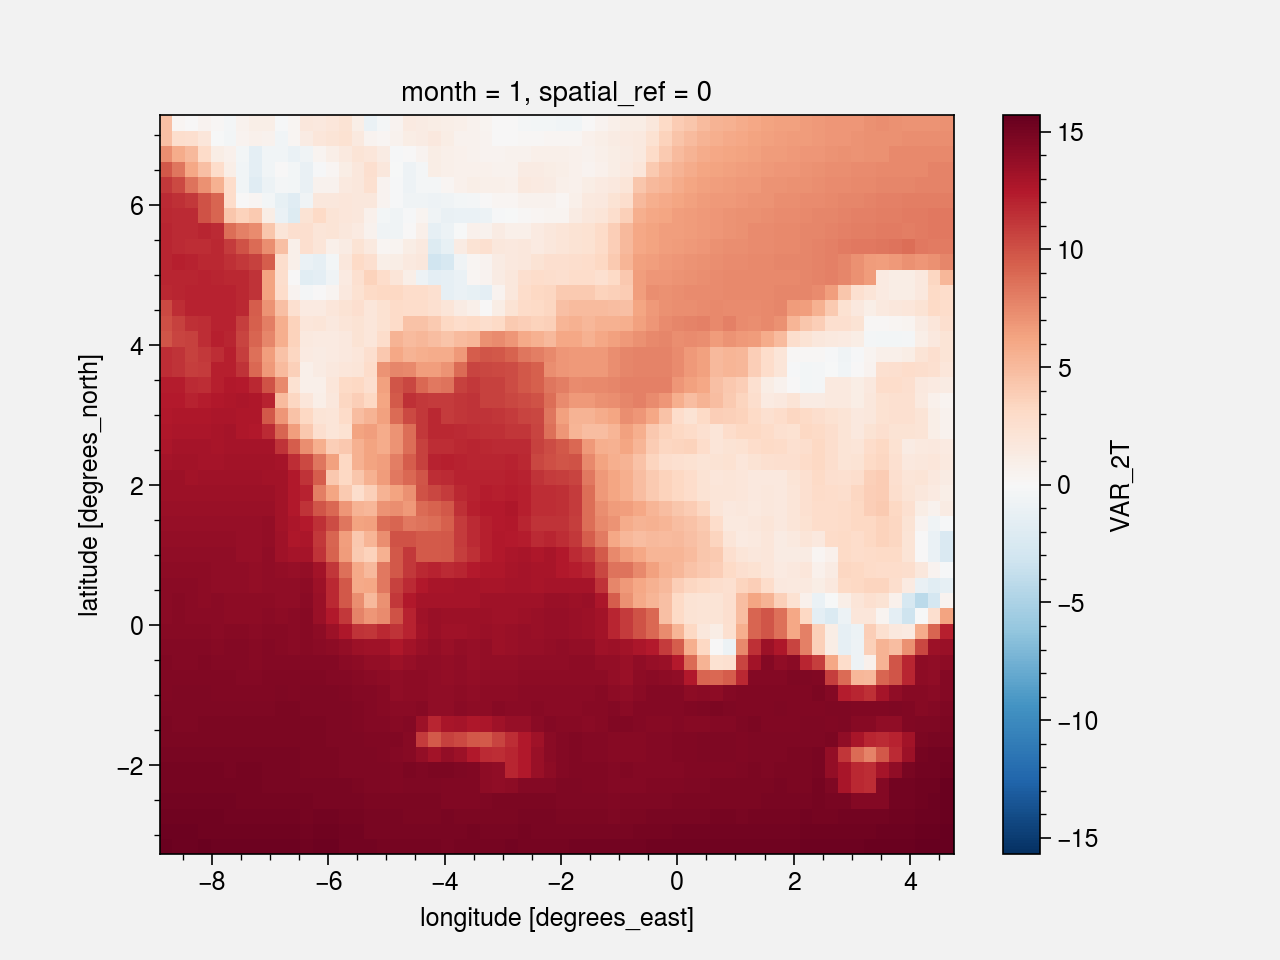

In [32]:
# ERA5 sample image
average_bymonth_reprojected[0].plot()

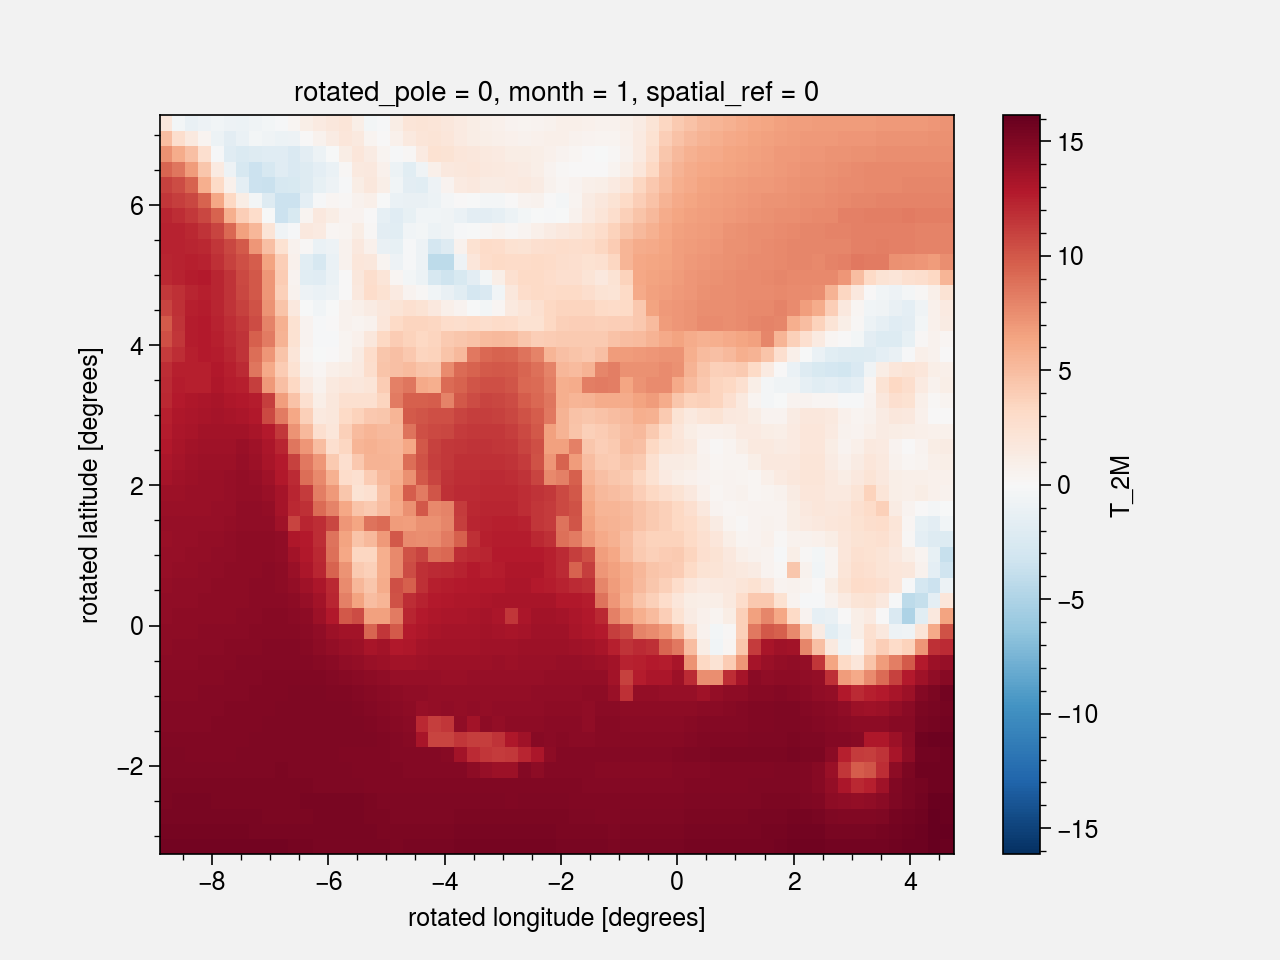

In [33]:
# MODEL sample image
average_bymonth_model[0].plot()

-------------

## 6. Visualization

### 6.1 Interpolate Datasets

In [34]:
rlat, rlon = average_model.indexes.values()

# interpolate month averages
average_reprojected_interp = average_reprojected.interp(rlon=rlon, rlat=rlat, method="nearest")
average_model_interp = average_model.interp(rlon=rlon, rlat=rlat, method="nearest")

# interpolate single monthly averages
average_bymonth_reprojected_interp = average_bymonth_reprojected.interp(rlon=rlon, rlat=rlat, method="nearest")
average_bymonth_model_interp = average_bymonth_model.interp(rlon=rlon, rlat=rlat, method="nearest")

### 6.2 Facet Graphic

In [35]:
average_difference = average_reprojected_interp - average_model_interp

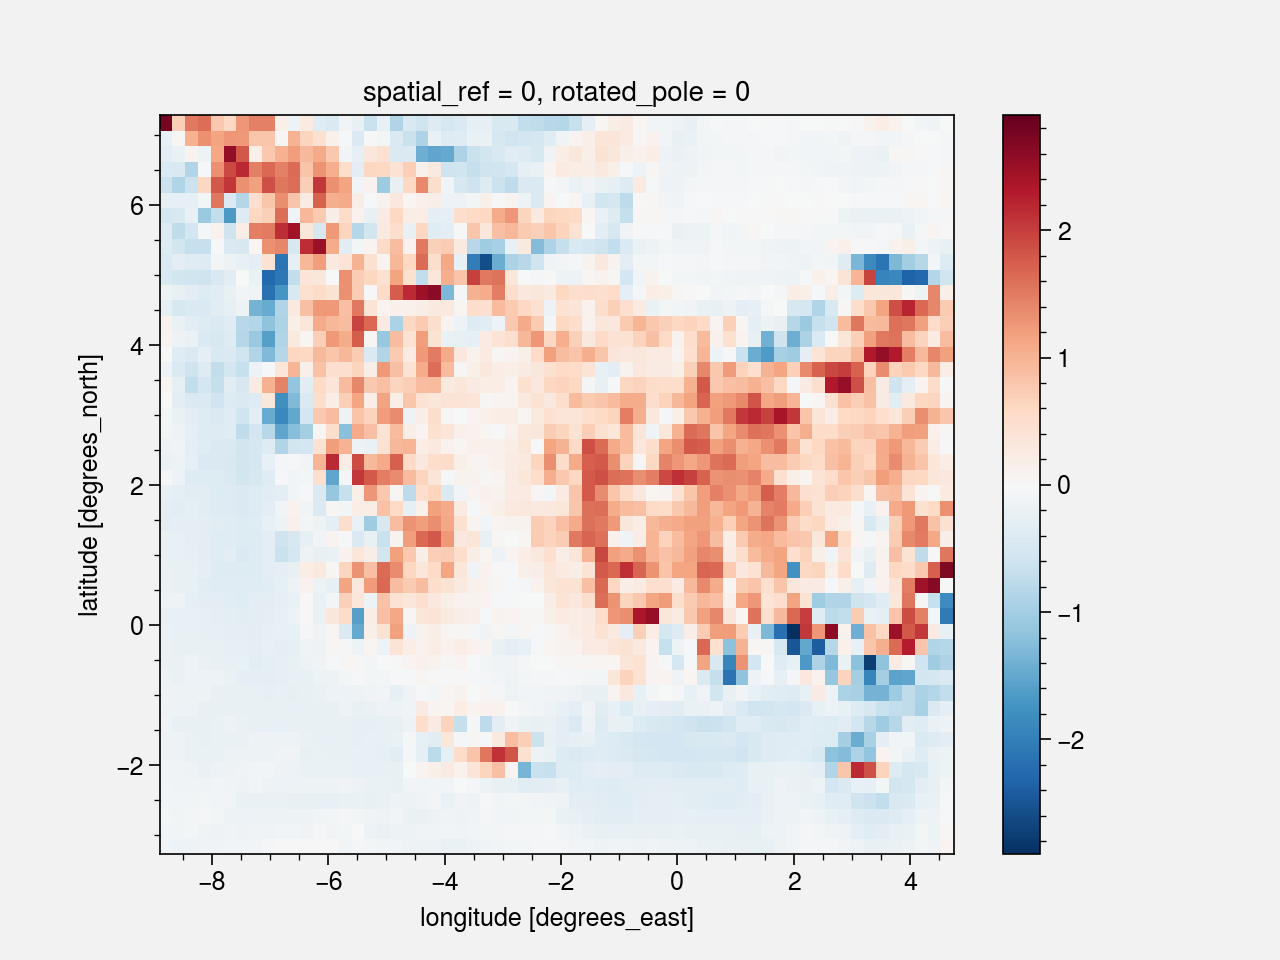

In [36]:
average_difference.plot()

### 6.2.1 Monhtly Mean Graphic

In [37]:
average_bymonth_difference = average_bymonth_reprojected_interp - average_bymonth_model_interp

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


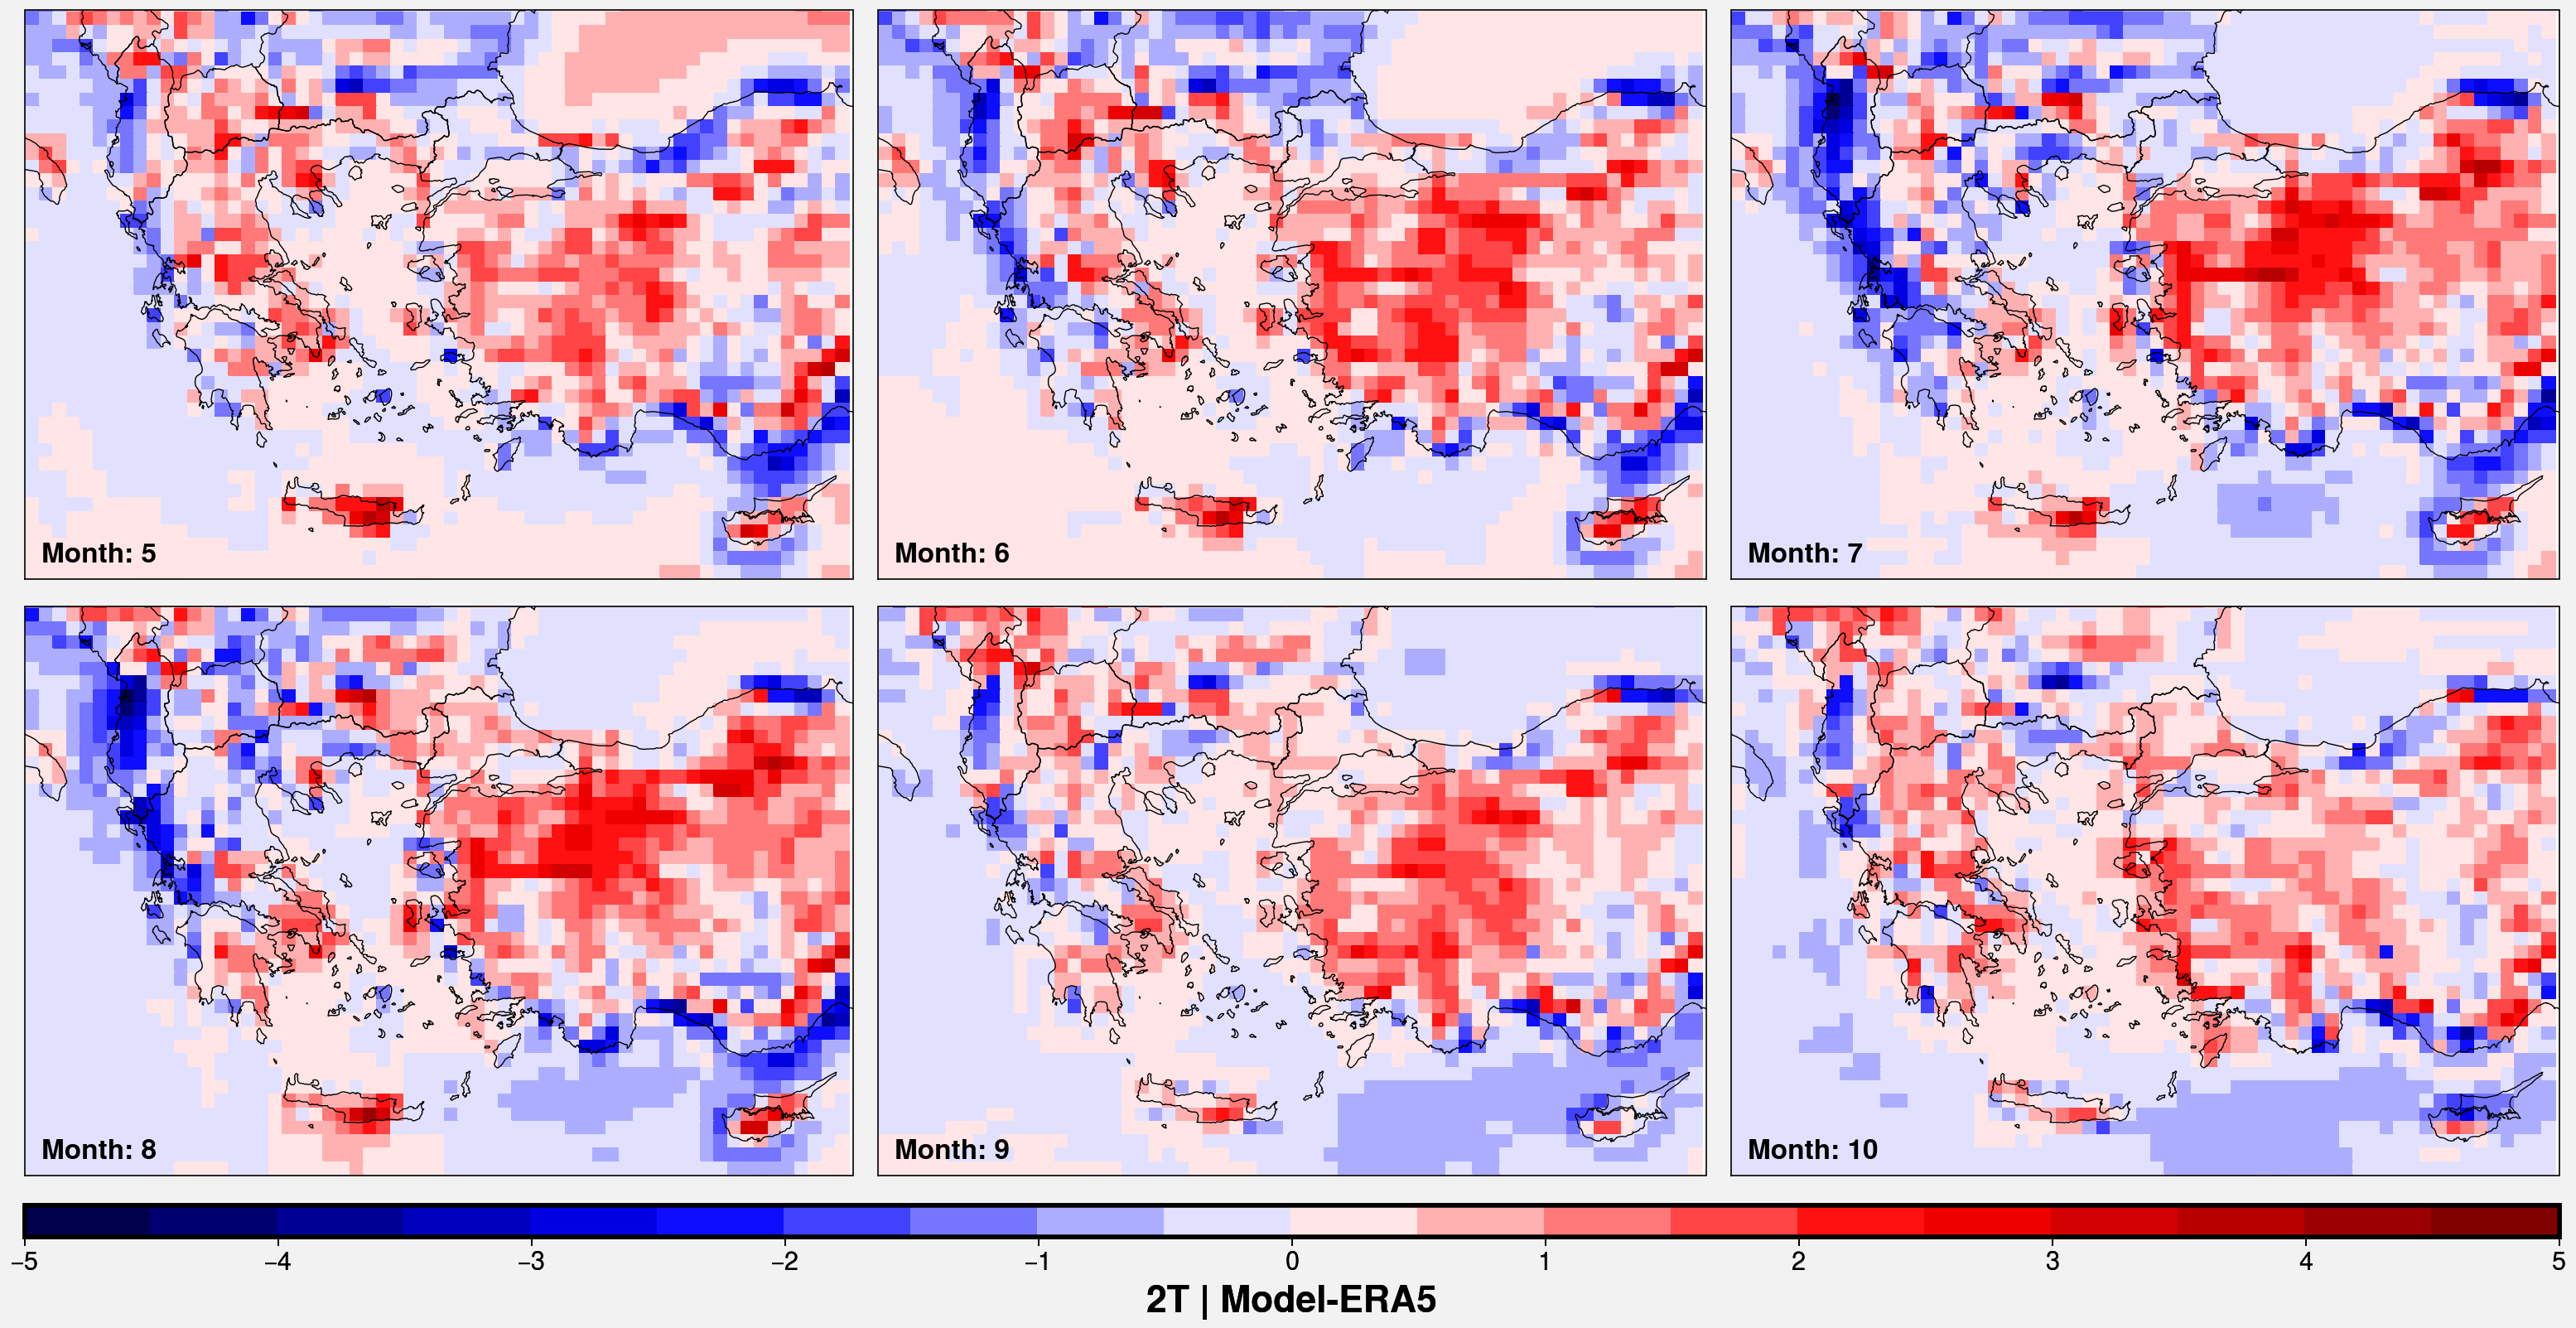

In [102]:
# data
data_df = average_bymonth_difference.sel(month=slice(5,10))

# graphic features
fig_array = [[1,2,3],
            [4,5,6],]

cmap = plt.get_cmap('seismic')
vmin = -5
vmax = 5
norm = BoundaryNorm(np.arange(vmin, vmax+0.5, 0.5), ncolors=cmap.N, clip=True)
ticks = np.arange(vmin, vmax + 1, 1)
graphic_no = 6
method='Month'

# projection
crs_data = cartopy.crs.RotatedPole(**crs_parameters)

plot_facet_map(data_df, cmap, vmin, vmax, norm, ticks,
               crs_data, graphic_no, var_name, model_level,
               plevel, method, fig_array)

### 6.2.2 Seasonal Mean Graphic

In [84]:
# seasonal means of each data
season_era5 = concat_season_means(average_bymonth_reprojected_interp)
season_model = concat_season_means(average_bymonth_model_interp)

# seasonal difference between data
season_difference = season_era5 - season_model

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:94: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  result = func(self, *args, **kwargs)


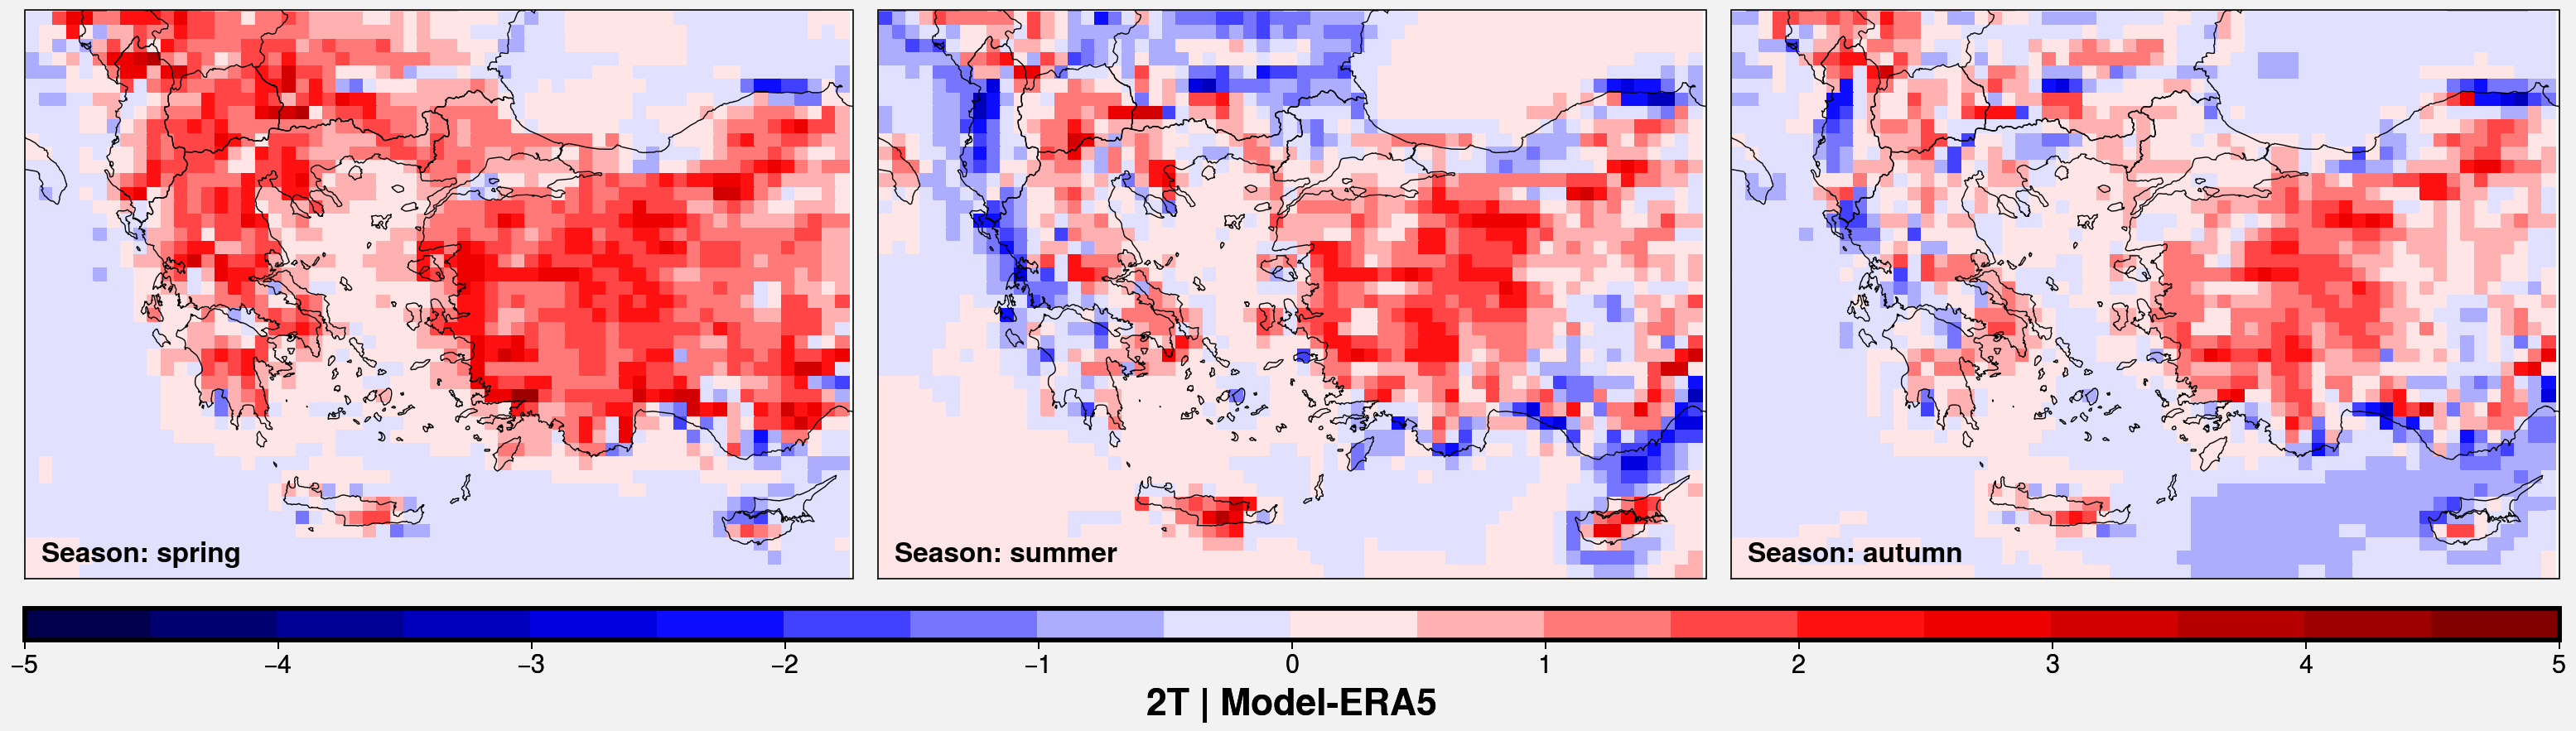

In [105]:
# data
data_df = season_difference

# graphic features
fig_array = [[1,2,3],
            ]

cmap = plt.get_cmap('seismic')
vmin = -5
vmax = 5
norm = BoundaryNorm(np.arange(vmin, vmax+0.5, 0.5), ncolors=cmap.N, clip=True)
ticks = np.arange(vmin, vmax + 1, 1)
graphic_no = 3
method='Season'

# projection
crs_data = cartopy.crs.RotatedPole(**crs_parameters)

plot_facet_map(data_df, cmap, vmin, vmax, norm, ticks,
               crs_data, graphic_no, var_name, model_level,
               plevel, method, fig_array)